In [170]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',150)

%matplotlib inline

In [171]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
test  = pd.read_csv('https://raw.githubusercontent.com/nikipi/Text_as_data/master/Tweet_sentiment/test_tweets_anuFYb8.csv')
train = pd.read_csv('https://raw.githubusercontent.com/nikipi/Text_as_data/master/Tweet_sentiment/train_E6oV3lV.csv')

In [172]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


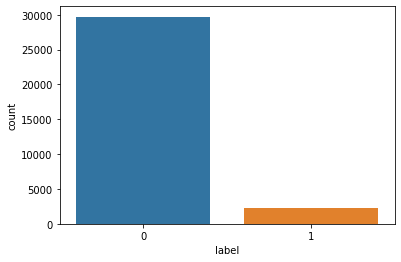

In [173]:
import seaborn as sns

sns.countplot(x='label', data=train)

In [174]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

## Unbalanced target variable-- undersampling or upsampling

In [175]:
from sklearn.utils import resample

In [176]:
train_majority=train[train['label']==0]
train_minority=train[train['label']==1]

In [177]:
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=29720,    # to match majority class
                                 random_state=123) # reproducible results

In [178]:
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

In [179]:
train_upsampled.label.value_counts()

1    29720
0    29720
Name: label, dtype: int64

## Preprocess the text

In [180]:
print(test.shape)
print(train_upsampled.shape)

(17197, 2)
(59440, 3)


In [181]:
combi = train_upsampled.append(test, ignore_index=True)

In [182]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z1-9]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [183]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [184]:
X = []
sentences = list(combi['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [185]:
len(X)

76637

In [186]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer



In [187]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit_transform(X)

In [188]:
train2=vect[:59440,:]
test2=vect[59440:,:]

In [189]:
X_train, X_test, y_train, y_test = train_test_split(train2, train_upsampled['label'], test_size=0.20, random_state=42)

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.9817720363778003


/Users/apple/PycharmProjects/PRACTICE/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [196]:
pred = model.predict(test2)
pred=pd.DataFrame(pred,columns=["label"])
pred.head()
pred['label'].value_counts()

0    15689
1     1508
Name: label, dtype: int64

In [197]:
test['label'] = pred['label']

In [198]:
test['label'] = pred['label']
submission = test[['id','label']]
submission.to_csv('/Users/apple/Desktop/submiss.csv', index=False) # writing data to a CSV file

In [219]:
pred2 = model.predict_proba(test2)
pred2=pd.DataFrame(pred2,columns=['zero','one'])

In [220]:
pred2.head()

,zero,one
0,0.935817,0.064183
1,0.502681,0.497319
2,0.995545,0.004455
3,0.962437,0.037563
4,0.999862,0.000138


In [253]:
def compare(a):
    if a>0.8:
        return 1
    else:
        return 0
        

In [254]:
pred2['label']=pred2.apply(lambda x : compare(x['one']),axis = 1)

In [255]:
pred2.head()

,zero,one,label
0,0.935817,0.064183,0
1,0.502681,0.497319,0
2,0.995545,0.004455,0
3,0.962437,0.037563,0
4,0.999862,0.000138,0


In [256]:
pred2['label'].value_counts()

0    16187
1     1010
Name: label, dtype: int64

In [257]:
test['label'] = pred2['label']
submission = test[['id','label']]
submission.to_csv('/Users/apple/Desktop/submiss.csv', index=False) # writin